In [1]:
import gym
import pybullet_envs
import random
import numpy as np
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import time
from gym.envs.registration import register
from IPython.display import clear_output
from itertools import count

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
env = gym.make('HalfCheetah-v2')
print('observation_space:', env.observation_space.shape)
print('action_space:', env.action_space.shape)

observation_space: (17,)
action_space: (6,)


In [4]:
print(env.action_space.high, env.action_space.low)

[1. 1. 1. 1. 1. 1.] [-1. -1. -1. -1. -1. -1.]


In [5]:
from collections import deque

class Memory:
    def __init__(self, maxlen=1000000):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, item):
        self.buffer.append(item)
       
    def replay(self, size):
        samples = random.sample(self.buffer, size)
        def atleast_2d(a): # ensure at least shape (size, 1) instead of (size,)
            return np.expand_dims(a, axis=1) if a.ndim < 2 else a
        samples = [atleast_2d(np.asarray(sample, dtype=np.float64)) for sample in zip(*samples)]
        
        return samples

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, concatenate

class Actor:
    def __init__(self, state_dim, action_dim, action_low, action_high):
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        
        inputs = Input((state_dim,))
        hidden = Dense(128, activation='relu')(inputs)
        hidden = Dense(128, activation='relu')(hidden)
        outputs = Dense(action_dim, activation='tanh', kernel_initializer=last_init)(hidden)
        def rescale(x):
            return x * action_high
        outputs = Lambda(rescale)(outputs)
        
        self.model = Model(inputs, outputs)
        
        self.action_low = action_low
        self.action_high = action_high
        
        self.mu = 0.0
        self.sigma = 0.1
        
    def select(self, state, add_noise=True):
        states = np.expand_dims(state, axis=0)
        action = self.model(states)
        if add_noise:
            action += np.random.normal(self.mu, self.sigma, size=action.shape)
            
        action = np.clip(action, self.action_low, self.action_high)
        return action

In [7]:
class Critic:
    def __init__(self, state_dim, action_dim):
        state_in = Input((state_dim,))
        action_in = Input((action_dim,))
        concat = concatenate([state_in, action_in])
        hidden = Dense(128, activation='relu')(concat)
        hidden = Dense(128, activation='relu')(hidden)
        output = Dense(1, activation='linear')(hidden)
        
        self.model = Model([state_in, action_in], output)

In [8]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [9]:
class Agent:
    def __init__(self, env):
        state_dim = np.squeeze(env.observation_space.shape)
        action_dim = np.squeeze(env.action_space.shape)
        
        self.state_dim, self.action_dim = state_dim, action_dim
        
        action_high = env.action_space.high
        action_low = env.action_space.low
        
        '''Initialize critic networks Qθ1, Qθ2, 
        and actor network πφ with random parameters θ1, θ2, φ'''
        self.critic_1 = Critic(state_dim, action_dim)
        self.critic_2 = Critic(state_dim, action_dim)
        self.actor = Actor(state_dim, action_dim, action_low, action_high)
        
        '''Initialize target networks θ1' ← θ1, θ2' ← θ2, φ' ← φ'''
        self.target_critic_1 = Critic(state_dim, action_dim)
        self.target_critic_1.model.set_weights(self.critic_1.model.get_weights())
        
        self.target_critic_2 = Critic(state_dim, action_dim)
        self.target_critic_2.model.set_weights(self.critic_2.model.get_weights())
        
        self.target_actor = Actor(state_dim, action_dim, action_low, action_high)
        self.target_actor.model.set_weights(self.actor.model.get_weights())
        
        '''Initialize replay buffer B'''
        self.memory = Memory(1000000)
        self.batch_size = 64
        
        self.policy_noise = 0.2
        self.noise_clip = 0.5
        
        self.total_epochs = 0
        self.policy_update = 2
        
        self.gamma = 0.99
        
        self.actor_optimizer = tf.keras.optimizers.Adam(lr=0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(lr=0.001)
        
        self.tau = 0.005
    
    @tf.function
    def update_actor(self, states):
        '''Update φ by the deterministic policy gradient:
            ∇φJ(φ) = N −1 P∇aQθ1(s, a)|a=πφ(s)∇φπφ(s)'''
        with tf.GradientTape() as tape:
            actions = self.actor.model(states)
            actor_loss = -tf.reduce_mean(self.critic_1.model([states, actions]))
            # minus sign to maximize critic value --> max(Q[i])
        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.model.trainable_variables))

    @tf.function
    def train(self, states, actions, rewards, next_states, not_dones):
        '''e ∼ clip(N (0, σ˜), −c, c)'''
        noise = tf.random.normal(actions.shape, 0, self.policy_noise, tf.float64)
        noise = tf.clip_by_value(noise, -self.noise_clip, self.noise_clip)

        '''a˜ ← πφ0 (s') + e'''
        next_action = self.target_actor.model(next_states)
        next_action = tf.clip_by_value(
            next_action + noise, 
            self.actor.action_low, 
            self.actor.action_high
        )

        '''y ← r + γ mini=1,2 Qθ(',i)(s', a˜)'''
        target_Q_1 = self.target_critic_1.model([next_states, next_action])
        target_Q_2 = self.target_critic_2.model([next_states, next_action])
        target_Q = rewards + self.gamma * tf.minimum(target_Q_1, target_Q_2) * not_dones
        
        '''Update critics θi ← argminθi N −1 P(y−Qθi(s, a))2'''
        with tf.GradientTape() as tape:
            Q_1 = self.critic_1.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q_1))
        grad = tape.gradient(loss, self.critic_1.model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grad, self.critic_1.model.trainable_variables))

        with tf.GradientTape() as tape:
            Q_2 = self.critic_2.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q_2))
        grad = tape.gradient(loss, self.critic_2.model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grad, self.critic_2.model.trainable_variables))
        
agent = Agent(env)

In [10]:
def run(agent, max_episode=100):
    history = []
    for ep in range(max_episode):
        state = env.reset()
        ep_reward = 0
        
        '''for t = 1 to T do'''
        for step in count():
            '''Select action with exploration noise a ∼ πφ(s) + e, e ∼ N (0, σ)'''
            action = agent.actor.select(state)[0]
            
            '''and observe reward r and new state s'''
            next_state, reward, done, _ = env.step(action)
            
            '''Store transition tuple (s, a, r, s') in B'''
            agent.memory.add((state, action, reward, next_state, 1 - done))

            if len(agent.memory.buffer) >= agent.batch_size:
                agent.total_epochs += 1
                samples = agent.memory.replay(agent.batch_size)

                '''Sample mini-batch of N transitions (s, a, r, s') from B'''
                states, actions, rewards, next_states, not_dones = samples
                agent.train(states, actions, rewards, next_states, not_dones)

                '''if t mod d then'''
                if agent.total_epochs % agent.policy_update == 0:
                    agent.update_actor(states)

                    '''Update target networks:'''
                    '''θ'i ← τθi + (1 − τ )θ'i
                    φ' ← τφ + (1 − τ )φ`'''
                    update_target(agent.target_critic_1.model.variables, agent.critic_1.model.variables, agent.tau)
                    update_target(agent.target_critic_2.model.variables, agent.critic_2.model.variables, agent.tau)
                    update_target(agent.target_actor.model.variables, agent.actor.model.variables, agent.tau)

            ep_reward += reward
            
            if done:
                break
            state = next_state
            
        history.append(ep_reward)
        print('Episode: {}, ep_reward: {}, step: {}'.format(ep, ep_reward, step + 1))
    
    return history

In [11]:
history = run(agent, 10000)

Episode: 0, ep_reward: -431.2820534038085, step: 1000
Episode: 1, ep_reward: -269.08763907856815, step: 1000
Episode: 2, ep_reward: -420.8592434765882, step: 1000
Episode: 3, ep_reward: -570.1677030211368, step: 1000
Episode: 4, ep_reward: -416.03628093703395, step: 1000
Episode: 5, ep_reward: -391.7565794480991, step: 1000
Episode: 6, ep_reward: -500.4269500955563, step: 1000
Episode: 7, ep_reward: -338.8160004074987, step: 1000
Episode: 8, ep_reward: -219.35548808624273, step: 1000
Episode: 9, ep_reward: -246.48140164316408, step: 1000
Episode: 10, ep_reward: -320.27427605849607, step: 1000
Episode: 11, ep_reward: 302.0965371523312, step: 1000
Episode: 12, ep_reward: -255.836164526688, step: 1000
Episode: 13, ep_reward: -168.76281318820168, step: 1000
Episode: 14, ep_reward: 52.695860919309816, step: 1000
Episode: 15, ep_reward: 93.71803092728757, step: 1000
Episode: 16, ep_reward: -39.390457493866684, step: 1000
Episode: 17, ep_reward: 192.7460993100509, step: 1000
Episode: 18, ep_r

Episode: 150, ep_reward: 2811.508291189543, step: 1000
Episode: 151, ep_reward: 2776.2244541001533, step: 1000
Episode: 152, ep_reward: 2750.8561577027526, step: 1000
Episode: 153, ep_reward: 2775.922524028307, step: 1000
Episode: 154, ep_reward: 3012.419299289867, step: 1000
Episode: 155, ep_reward: 2934.7396826718605, step: 1000
Episode: 156, ep_reward: 2707.18775373428, step: 1000
Episode: 157, ep_reward: 3083.3852861538435, step: 1000
Episode: 158, ep_reward: 2931.844136848752, step: 1000
Episode: 159, ep_reward: 2856.125341703157, step: 1000
Episode: 160, ep_reward: 2795.779647835714, step: 1000
Episode: 161, ep_reward: 3037.536027090949, step: 1000
Episode: 162, ep_reward: 2958.927626184017, step: 1000
Episode: 163, ep_reward: 3149.906040062889, step: 1000
Episode: 164, ep_reward: 3114.803735845976, step: 1000
Episode: 165, ep_reward: 2982.3528345219925, step: 1000
Episode: 166, ep_reward: 3107.6409559829744, step: 1000
Episode: 167, ep_reward: 3030.0554103177874, step: 1000
Epis

Episode: 298, ep_reward: 3967.839390759363, step: 1000
Episode: 299, ep_reward: 3754.2070084038405, step: 1000
Episode: 300, ep_reward: 3969.759158568785, step: 1000
Episode: 301, ep_reward: 3739.188853039338, step: 1000
Episode: 302, ep_reward: 3832.2217048092334, step: 1000
Episode: 303, ep_reward: 3944.514311363742, step: 1000
Episode: 304, ep_reward: 4024.4741967889927, step: 1000
Episode: 305, ep_reward: 3805.647539816721, step: 1000
Episode: 306, ep_reward: 3878.0691267702555, step: 1000
Episode: 307, ep_reward: 3834.8142414435633, step: 1000
Episode: 308, ep_reward: 3861.5513356436936, step: 1000
Episode: 309, ep_reward: 3898.3956723813058, step: 1000
Episode: 310, ep_reward: 3806.3684626373856, step: 1000
Episode: 311, ep_reward: 3827.320177205054, step: 1000
Episode: 312, ep_reward: 1919.5122191286277, step: 1000
Episode: 313, ep_reward: 3954.275222621441, step: 1000
Episode: 314, ep_reward: 4049.1322510915707, step: 1000
Episode: 315, ep_reward: 4178.439930466556, step: 1000


Episode: 447, ep_reward: 4102.059431720327, step: 1000
Episode: 448, ep_reward: 4080.397033780572, step: 1000
Episode: 449, ep_reward: 3903.8105943912974, step: 1000
Episode: 450, ep_reward: 4291.683887708648, step: 1000
Episode: 451, ep_reward: 4212.958682262909, step: 1000
Episode: 452, ep_reward: 4140.488742573019, step: 1000
Episode: 453, ep_reward: 4062.304105931002, step: 1000
Episode: 454, ep_reward: 4101.955908831435, step: 1000
Episode: 455, ep_reward: 4230.579081058269, step: 1000
Episode: 456, ep_reward: 4031.8339712110665, step: 1000
Episode: 457, ep_reward: 4196.600567531274, step: 1000
Episode: 458, ep_reward: 4161.1789336500415, step: 1000
Episode: 459, ep_reward: 4097.886810740802, step: 1000
Episode: 460, ep_reward: 4275.28320746418, step: 1000
Episode: 461, ep_reward: 4367.888388976994, step: 1000
Episode: 462, ep_reward: 4169.70846439917, step: 1000
Episode: 463, ep_reward: 4341.491580423558, step: 1000
Episode: 464, ep_reward: 4213.664614779445, step: 1000
Episode: 

Episode: 596, ep_reward: 4029.2171874298633, step: 1000
Episode: 597, ep_reward: 4311.953479385697, step: 1000
Episode: 598, ep_reward: 4330.609096342532, step: 1000
Episode: 599, ep_reward: 4087.297086518497, step: 1000
Episode: 600, ep_reward: 4160.839113461765, step: 1000
Episode: 601, ep_reward: 4232.787085940671, step: 1000
Episode: 602, ep_reward: 4298.390562143489, step: 1000
Episode: 603, ep_reward: 4066.2433644581447, step: 1000
Episode: 604, ep_reward: 4305.712322077194, step: 1000
Episode: 605, ep_reward: 4461.509178610138, step: 1000
Episode: 606, ep_reward: 4209.76015755212, step: 1000
Episode: 607, ep_reward: 3966.5987342050494, step: 1000
Episode: 608, ep_reward: 4172.869943747915, step: 1000
Episode: 609, ep_reward: 4283.6553815311, step: 1000
Episode: 610, ep_reward: 4216.316837256139, step: 1000
Episode: 611, ep_reward: 4285.636056100671, step: 1000
Episode: 612, ep_reward: 4254.080323055249, step: 1000
Episode: 613, ep_reward: 4381.688006693143, step: 1000
Episode: 6

Episode: 745, ep_reward: 4470.279402433228, step: 1000
Episode: 746, ep_reward: 4349.889667100573, step: 1000
Episode: 747, ep_reward: 4435.689360273525, step: 1000
Episode: 748, ep_reward: 4524.725782457897, step: 1000
Episode: 749, ep_reward: 4398.327637339423, step: 1000
Episode: 750, ep_reward: 4219.190794188316, step: 1000
Episode: 751, ep_reward: 4402.079853751761, step: 1000
Episode: 752, ep_reward: 4378.452053370012, step: 1000
Episode: 753, ep_reward: 4390.461504700414, step: 1000
Episode: 754, ep_reward: 4143.312047913158, step: 1000
Episode: 755, ep_reward: 4397.293302866537, step: 1000
Episode: 756, ep_reward: 4597.948122848127, step: 1000
Episode: 757, ep_reward: 4471.374057928963, step: 1000
Episode: 758, ep_reward: 3524.930538526652, step: 1000
Episode: 759, ep_reward: 4605.178349303406, step: 1000
Episode: 760, ep_reward: 4346.569022988339, step: 1000
Episode: 761, ep_reward: 4365.775395607241, step: 1000
Episode: 762, ep_reward: 4522.901811304837, step: 1000
Episode: 7

Episode: 894, ep_reward: 4455.782365216051, step: 1000
Episode: 895, ep_reward: 4692.478735082422, step: 1000
Episode: 896, ep_reward: 4458.700029352157, step: 1000
Episode: 897, ep_reward: 4660.482106272933, step: 1000
Episode: 898, ep_reward: 4479.774916420884, step: 1000
Episode: 899, ep_reward: 4575.207031391274, step: 1000
Episode: 900, ep_reward: 4666.047333290094, step: 1000
Episode: 901, ep_reward: 4654.167238438056, step: 1000
Episode: 902, ep_reward: 4340.04379969985, step: 1000
Episode: 903, ep_reward: 4428.646933910398, step: 1000
Episode: 904, ep_reward: 4549.681950033187, step: 1000
Episode: 905, ep_reward: 4410.398484215672, step: 1000
Episode: 906, ep_reward: 4686.765829610655, step: 1000
Episode: 907, ep_reward: 4645.083339616806, step: 1000
Episode: 908, ep_reward: 4668.10019404655, step: 1000
Episode: 909, ep_reward: 4623.94820766957, step: 1000
Episode: 910, ep_reward: 4644.441286808001, step: 1000
Episode: 911, ep_reward: 4665.22258985832, step: 1000
Episode: 912, 

Episode: 1043, ep_reward: 4745.192446053309, step: 1000
Episode: 1044, ep_reward: 4633.001809038104, step: 1000
Episode: 1045, ep_reward: 4700.914501367557, step: 1000
Episode: 1046, ep_reward: 4733.5729594191735, step: 1000
Episode: 1047, ep_reward: 4613.394620859871, step: 1000
Episode: 1048, ep_reward: 4616.843580101439, step: 1000
Episode: 1049, ep_reward: 4615.600964677986, step: 1000
Episode: 1050, ep_reward: 4625.2424316901215, step: 1000
Episode: 1051, ep_reward: 4936.201503649776, step: 1000
Episode: 1052, ep_reward: 4781.373925987459, step: 1000
Episode: 1053, ep_reward: 4801.465234125147, step: 1000
Episode: 1054, ep_reward: 4537.219579055874, step: 1000
Episode: 1055, ep_reward: 4891.710091477253, step: 1000
Episode: 1056, ep_reward: 4806.644294842651, step: 1000
Episode: 1057, ep_reward: 4592.74811571536, step: 1000
Episode: 1058, ep_reward: 4758.890194835928, step: 1000
Episode: 1059, ep_reward: 4764.472321495867, step: 1000
Episode: 1060, ep_reward: 4600.328305169338, st

Episode: 1190, ep_reward: 4957.131418231231, step: 1000
Episode: 1191, ep_reward: 4459.518061468663, step: 1000
Episode: 1192, ep_reward: 4916.406042337511, step: 1000
Episode: 1193, ep_reward: 4895.409744914338, step: 1000
Episode: 1194, ep_reward: 4818.645745082502, step: 1000
Episode: 1195, ep_reward: 4905.462998517517, step: 1000
Episode: 1196, ep_reward: 4912.975004312265, step: 1000
Episode: 1197, ep_reward: 4939.5819229343515, step: 1000
Episode: 1198, ep_reward: 4906.656110650248, step: 1000
Episode: 1199, ep_reward: 4654.179813304075, step: 1000
Episode: 1200, ep_reward: 4871.019036342315, step: 1000
Episode: 1201, ep_reward: 4774.595677248002, step: 1000
Episode: 1202, ep_reward: 4871.208291664459, step: 1000
Episode: 1203, ep_reward: 4914.563131495132, step: 1000
Episode: 1204, ep_reward: 4788.851494413186, step: 1000
Episode: 1205, ep_reward: 1467.275114520655, step: 1000
Episode: 1206, ep_reward: 4797.223269411207, step: 1000
Episode: 1207, ep_reward: 4834.958113676247, st

Episode: 1337, ep_reward: 5245.519529590509, step: 1000
Episode: 1338, ep_reward: 5071.748316575695, step: 1000
Episode: 1339, ep_reward: 5032.459466711443, step: 1000
Episode: 1340, ep_reward: 5085.890579362219, step: 1000
Episode: 1341, ep_reward: 4909.66247877541, step: 1000
Episode: 1342, ep_reward: 4768.469567390638, step: 1000
Episode: 1343, ep_reward: 4830.240183987561, step: 1000
Episode: 1344, ep_reward: 4928.264144493277, step: 1000
Episode: 1345, ep_reward: 5254.70868342157, step: 1000
Episode: 1346, ep_reward: 454.61151866689335, step: 1000
Episode: 1347, ep_reward: 4974.109874484516, step: 1000
Episode: 1348, ep_reward: 4913.8437269414, step: 1000
Episode: 1349, ep_reward: 5002.356184952766, step: 1000
Episode: 1350, ep_reward: 5026.380567315051, step: 1000
Episode: 1351, ep_reward: 5139.11652616462, step: 1000
Episode: 1352, ep_reward: 4782.674296914527, step: 1000
Episode: 1353, ep_reward: 5051.967001595506, step: 1000
Episode: 1354, ep_reward: 5008.511972179849, step: 1

Episode: 1484, ep_reward: 5080.563116371224, step: 1000
Episode: 1485, ep_reward: 5053.016374027036, step: 1000
Episode: 1486, ep_reward: 5245.774703071607, step: 1000
Episode: 1487, ep_reward: 5015.575551335226, step: 1000
Episode: 1488, ep_reward: 5408.951425677754, step: 1000
Episode: 1489, ep_reward: 5251.2193295957195, step: 1000
Episode: 1490, ep_reward: 5113.614152387559, step: 1000
Episode: 1491, ep_reward: 5151.109130451952, step: 1000
Episode: 1492, ep_reward: 5218.881813544167, step: 1000
Episode: 1493, ep_reward: 5214.6165438064745, step: 1000
Episode: 1494, ep_reward: 4892.60424526885, step: 1000
Episode: 1495, ep_reward: 5199.706503976665, step: 1000
Episode: 1496, ep_reward: 5228.856705271978, step: 1000
Episode: 1497, ep_reward: 5242.139365148156, step: 1000
Episode: 1498, ep_reward: 5279.3907991707165, step: 1000
Episode: 1499, ep_reward: 5136.233943326837, step: 1000
Episode: 1500, ep_reward: 5361.42980630293, step: 1000
Episode: 1501, ep_reward: 5175.423775191857, st

Episode: 1631, ep_reward: 5737.422727926096, step: 1000
Episode: 1632, ep_reward: 6058.278141507599, step: 1000
Episode: 1633, ep_reward: 5894.01550517824, step: 1000
Episode: 1634, ep_reward: 5915.609490754738, step: 1000
Episode: 1635, ep_reward: 6039.925162938911, step: 1000
Episode: 1636, ep_reward: 5996.2715214079835, step: 1000
Episode: 1637, ep_reward: 5822.457451606934, step: 1000
Episode: 1638, ep_reward: 5927.009652236674, step: 1000
Episode: 1639, ep_reward: 5893.905677741051, step: 1000
Episode: 1640, ep_reward: 5689.631667237224, step: 1000
Episode: 1641, ep_reward: 6101.086514452523, step: 1000
Episode: 1642, ep_reward: 5760.104595321177, step: 1000
Episode: 1643, ep_reward: 5845.634977494909, step: 1000
Episode: 1644, ep_reward: 5989.147986245429, step: 1000
Episode: 1645, ep_reward: 5781.744760453599, step: 1000
Episode: 1646, ep_reward: 5882.041903944996, step: 1000
Episode: 1647, ep_reward: 5954.116096696671, step: 1000
Episode: 1648, ep_reward: 6124.437961601163, ste

Episode: 1778, ep_reward: 6062.3452017584805, step: 1000
Episode: 1779, ep_reward: 6161.5994231083905, step: 1000
Episode: 1780, ep_reward: 6469.569740994649, step: 1000
Episode: 1781, ep_reward: 6411.356946353464, step: 1000
Episode: 1782, ep_reward: 6199.85025869643, step: 1000
Episode: 1783, ep_reward: 6149.132126575323, step: 1000
Episode: 1784, ep_reward: 6267.939806666082, step: 1000
Episode: 1785, ep_reward: 6394.936732726107, step: 1000
Episode: 1786, ep_reward: 6309.872480241459, step: 1000
Episode: 1787, ep_reward: 6320.632822334687, step: 1000
Episode: 1788, ep_reward: 6250.649332290988, step: 1000
Episode: 1789, ep_reward: 6471.033396951689, step: 1000
Episode: 1790, ep_reward: 6327.462627309991, step: 1000
Episode: 1791, ep_reward: 6288.719361691424, step: 1000
Episode: 1792, ep_reward: 6441.144993650012, step: 1000
Episode: 1793, ep_reward: 6549.690774887789, step: 1000
Episode: 1794, ep_reward: 6089.770039047092, step: 1000
Episode: 1795, ep_reward: 6035.165461652253, st

Episode: 1925, ep_reward: 6810.49280871786, step: 1000
Episode: 1926, ep_reward: 6723.799345634289, step: 1000
Episode: 1927, ep_reward: 6593.983106425885, step: 1000
Episode: 1928, ep_reward: 6627.362983143405, step: 1000
Episode: 1929, ep_reward: 6800.417776310217, step: 1000
Episode: 1930, ep_reward: 6618.7674535033275, step: 1000
Episode: 1931, ep_reward: 6588.548081634898, step: 1000
Episode: 1932, ep_reward: 6524.644542003347, step: 1000
Episode: 1933, ep_reward: 6525.219894849354, step: 1000
Episode: 1934, ep_reward: 6690.715022454995, step: 1000
Episode: 1935, ep_reward: 6706.612021866981, step: 1000
Episode: 1936, ep_reward: 6470.2377840607805, step: 1000
Episode: 1937, ep_reward: 6782.659504703765, step: 1000
Episode: 1938, ep_reward: 6569.351708090506, step: 1000
Episode: 1939, ep_reward: 6595.310006207625, step: 1000
Episode: 1940, ep_reward: 6702.923790815878, step: 1000
Episode: 1941, ep_reward: 6699.506191379916, step: 1000
Episode: 1942, ep_reward: 6743.825690095943, st

Episode: 2072, ep_reward: 6909.850508870872, step: 1000
Episode: 2073, ep_reward: 7069.660765220879, step: 1000
Episode: 2074, ep_reward: 6936.5288713107475, step: 1000
Episode: 2075, ep_reward: 7069.674951400343, step: 1000
Episode: 2076, ep_reward: 6654.765630778588, step: 1000
Episode: 2077, ep_reward: 6826.75592286489, step: 1000
Episode: 2078, ep_reward: 6968.164365387994, step: 1000
Episode: 2079, ep_reward: 6972.415656651161, step: 1000
Episode: 2080, ep_reward: 6923.798648754093, step: 1000
Episode: 2081, ep_reward: 7063.890749321989, step: 1000
Episode: 2082, ep_reward: 6858.961866968071, step: 1000
Episode: 2083, ep_reward: 7092.361194206364, step: 1000
Episode: 2084, ep_reward: 6883.425234097828, step: 1000
Episode: 2085, ep_reward: 6995.824269922074, step: 1000
Episode: 2086, ep_reward: 6862.577427536575, step: 1000
Episode: 2087, ep_reward: 6986.165562837913, step: 1000
Episode: 2088, ep_reward: 7138.020661969866, step: 1000
Episode: 2089, ep_reward: 6805.908387499412, ste

Episode: 2219, ep_reward: 7183.510574223461, step: 1000
Episode: 2220, ep_reward: 6828.334985258343, step: 1000
Episode: 2221, ep_reward: 7249.28784113309, step: 1000
Episode: 2222, ep_reward: 7064.786638169206, step: 1000
Episode: 2223, ep_reward: 4006.4974952865464, step: 1000
Episode: 2224, ep_reward: 7164.3868462123155, step: 1000
Episode: 2225, ep_reward: 6705.034078190923, step: 1000
Episode: 2226, ep_reward: 7279.686042382656, step: 1000
Episode: 2227, ep_reward: 6765.021403651204, step: 1000
Episode: 2228, ep_reward: 7189.132949156971, step: 1000
Episode: 2229, ep_reward: 7212.498993365291, step: 1000
Episode: 2230, ep_reward: 7419.374034259142, step: 1000
Episode: 2231, ep_reward: 7299.984445563517, step: 1000
Episode: 2232, ep_reward: 7179.424574049877, step: 1000
Episode: 2233, ep_reward: 7135.002550423748, step: 1000
Episode: 2234, ep_reward: 7268.269401437078, step: 1000
Episode: 2235, ep_reward: 7071.874008840853, step: 1000
Episode: 2236, ep_reward: 6887.378430204083, st

Episode: 2366, ep_reward: 7388.480961162331, step: 1000
Episode: 2367, ep_reward: 7284.8766961839965, step: 1000
Episode: 2368, ep_reward: 7341.231119450587, step: 1000
Episode: 2369, ep_reward: 7361.503230269818, step: 1000
Episode: 2370, ep_reward: 7299.526260107998, step: 1000
Episode: 2371, ep_reward: 7494.939334658722, step: 1000
Episode: 2372, ep_reward: 7050.035767883056, step: 1000
Episode: 2373, ep_reward: 7586.340651884273, step: 1000
Episode: 2374, ep_reward: 7409.710097926531, step: 1000
Episode: 2375, ep_reward: 7106.237882784746, step: 1000
Episode: 2376, ep_reward: 7429.488357990663, step: 1000
Episode: 2377, ep_reward: 7404.582006594959, step: 1000
Episode: 2378, ep_reward: 6770.890406365721, step: 1000
Episode: 2379, ep_reward: 7338.958700876681, step: 1000
Episode: 2380, ep_reward: 6887.75486333768, step: 1000
Episode: 2381, ep_reward: 7336.619216688252, step: 1000
Episode: 2382, ep_reward: 7298.223024860729, step: 1000
Episode: 2383, ep_reward: 7248.791288381076, ste

Episode: 2513, ep_reward: 6811.657674754303, step: 1000
Episode: 2514, ep_reward: 7630.3255218453305, step: 1000
Episode: 2515, ep_reward: 7443.708809304624, step: 1000
Episode: 2516, ep_reward: 7536.479570058147, step: 1000
Episode: 2517, ep_reward: 7454.293779078305, step: 1000
Episode: 2518, ep_reward: 7754.484793756233, step: 1000
Episode: 2519, ep_reward: 7339.624860190291, step: 1000
Episode: 2520, ep_reward: 7572.154133498424, step: 1000
Episode: 2521, ep_reward: 7339.971290924632, step: 1000
Episode: 2522, ep_reward: 7575.022095483188, step: 1000
Episode: 2523, ep_reward: 7737.363335365391, step: 1000
Episode: 2524, ep_reward: 7593.364742676918, step: 1000
Episode: 2525, ep_reward: 7266.006130975571, step: 1000
Episode: 2526, ep_reward: 7496.87534496327, step: 1000
Episode: 2527, ep_reward: 7054.614483408099, step: 1000
Episode: 2528, ep_reward: 7384.010965332186, step: 1000
Episode: 2529, ep_reward: 7099.617026819814, step: 1000
Episode: 2530, ep_reward: 7723.659814613985, ste

Episode: 2660, ep_reward: 7774.851830726947, step: 1000
Episode: 2661, ep_reward: 7350.4584545024245, step: 1000
Episode: 2662, ep_reward: 7627.090955960135, step: 1000
Episode: 2663, ep_reward: 7608.946831271065, step: 1000
Episode: 2664, ep_reward: 7583.7812553028825, step: 1000
Episode: 2665, ep_reward: 7767.623827803694, step: 1000
Episode: 2666, ep_reward: 7918.714951390241, step: 1000
Episode: 2667, ep_reward: 7655.346464221046, step: 1000
Episode: 2668, ep_reward: 8008.962355304811, step: 1000
Episode: 2669, ep_reward: 7652.271639284259, step: 1000
Episode: 2670, ep_reward: 7609.630022955385, step: 1000
Episode: 2671, ep_reward: 7518.354992155754, step: 1000
Episode: 2672, ep_reward: 7895.848568925696, step: 1000
Episode: 2673, ep_reward: 7354.949524774767, step: 1000
Episode: 2674, ep_reward: 7730.246401420734, step: 1000
Episode: 2675, ep_reward: 7592.073317993674, step: 1000
Episode: 2676, ep_reward: 7878.487712775282, step: 1000
Episode: 2677, ep_reward: 7722.962054771398, s

Episode: 2807, ep_reward: 7671.367525697477, step: 1000
Episode: 2808, ep_reward: 7697.358715629757, step: 1000
Episode: 2809, ep_reward: 7780.2912190575025, step: 1000
Episode: 2810, ep_reward: 7875.881829025263, step: 1000
Episode: 2811, ep_reward: 7580.129808843778, step: 1000
Episode: 2812, ep_reward: 7640.559010651527, step: 1000
Episode: 2813, ep_reward: 7603.344140621399, step: 1000
Episode: 2814, ep_reward: 7661.88385221359, step: 1000
Episode: 2815, ep_reward: 7884.206690462551, step: 1000
Episode: 2816, ep_reward: 7658.9953943346345, step: 1000
Episode: 2817, ep_reward: 7552.906545132366, step: 1000
Episode: 2818, ep_reward: 7632.411751903305, step: 1000
Episode: 2819, ep_reward: 7633.092351760065, step: 1000
Episode: 2820, ep_reward: 7718.300021688548, step: 1000
Episode: 2821, ep_reward: 7805.433669895982, step: 1000
Episode: 2822, ep_reward: 7685.98601013281, step: 1000
Episode: 2823, ep_reward: 7516.739885601503, step: 1000
Episode: 2824, ep_reward: 7582.450540769781, ste

Episode: 2954, ep_reward: 7554.232590504256, step: 1000
Episode: 2955, ep_reward: 7665.287866959318, step: 1000
Episode: 2956, ep_reward: 7695.996684033936, step: 1000
Episode: 2957, ep_reward: 7736.07022590534, step: 1000
Episode: 2958, ep_reward: 7574.169620079192, step: 1000
Episode: 2959, ep_reward: 7669.330840444616, step: 1000
Episode: 2960, ep_reward: 7559.861180489575, step: 1000
Episode: 2961, ep_reward: 7623.548400736129, step: 1000
Episode: 2962, ep_reward: 7647.077897262518, step: 1000
Episode: 2963, ep_reward: 7768.2881925956635, step: 1000
Episode: 2964, ep_reward: 7663.6776756912395, step: 1000
Episode: 2965, ep_reward: 7509.219387371955, step: 1000
Episode: 2966, ep_reward: 7560.881684679874, step: 1000
Episode: 2967, ep_reward: 7540.118356736834, step: 1000
Episode: 2968, ep_reward: 7735.746652696642, step: 1000
Episode: 2969, ep_reward: 7596.527845725517, step: 1000
Episode: 2970, ep_reward: 7766.695970874214, step: 1000
Episode: 2971, ep_reward: 7740.313628742433, st

Episode: 3101, ep_reward: 7792.634629297301, step: 1000
Episode: 3102, ep_reward: 7735.369550647512, step: 1000
Episode: 3103, ep_reward: 7809.601461297245, step: 1000
Episode: 3104, ep_reward: 7957.938296254284, step: 1000
Episode: 3105, ep_reward: 7871.916654973348, step: 1000
Episode: 3106, ep_reward: 7531.497726198687, step: 1000
Episode: 3107, ep_reward: 7569.9754222080865, step: 1000
Episode: 3108, ep_reward: 7758.690004763993, step: 1000
Episode: 3109, ep_reward: 7699.959118282436, step: 1000
Episode: 3110, ep_reward: 7566.399969291219, step: 1000
Episode: 3111, ep_reward: 8163.579753189243, step: 1000
Episode: 3112, ep_reward: 7679.332954687452, step: 1000
Episode: 3113, ep_reward: 7227.703545990624, step: 1000
Episode: 3114, ep_reward: 7873.244388317909, step: 1000
Episode: 3115, ep_reward: 7803.82688124263, step: 1000
Episode: 3116, ep_reward: 7882.816888388651, step: 1000
Episode: 3117, ep_reward: 7804.771145880809, step: 1000
Episode: 3118, ep_reward: 7832.889676766692, ste

Episode: 3248, ep_reward: 7913.068700569677, step: 1000
Episode: 3249, ep_reward: 7800.774839013087, step: 1000
Episode: 3250, ep_reward: 7947.448688929417, step: 1000
Episode: 3251, ep_reward: 8132.621210989535, step: 1000
Episode: 3252, ep_reward: 7855.166019105375, step: 1000
Episode: 3253, ep_reward: 7687.215992783763, step: 1000
Episode: 3254, ep_reward: 7864.650661792287, step: 1000
Episode: 3255, ep_reward: 7939.00893236575, step: 1000
Episode: 3256, ep_reward: 8020.817788949787, step: 1000
Episode: 3257, ep_reward: 7982.85435123239, step: 1000
Episode: 3258, ep_reward: 8156.272061383836, step: 1000
Episode: 3259, ep_reward: 7807.56154387918, step: 1000
Episode: 3260, ep_reward: 7953.8544571334905, step: 1000
Episode: 3261, ep_reward: 7614.888847666571, step: 1000
Episode: 3262, ep_reward: 7732.279488711926, step: 1000
Episode: 3263, ep_reward: 8026.4222882321965, step: 1000
Episode: 3264, ep_reward: 8172.416075538595, step: 1000
Episode: 3265, ep_reward: 7738.853936537948, step

Episode: 3395, ep_reward: 8078.536216222381, step: 1000
Episode: 3396, ep_reward: 8033.050598909752, step: 1000
Episode: 3397, ep_reward: 8202.503124256307, step: 1000
Episode: 3398, ep_reward: 8170.91824691108, step: 1000
Episode: 3399, ep_reward: 8000.205620880568, step: 1000
Episode: 3400, ep_reward: 8235.933272845692, step: 1000
Episode: 3401, ep_reward: 7947.512649338255, step: 1000
Episode: 3402, ep_reward: 8148.144943959913, step: 1000
Episode: 3403, ep_reward: 7704.820330422767, step: 1000
Episode: 3404, ep_reward: 7808.218285049533, step: 1000
Episode: 3405, ep_reward: 8057.987428506042, step: 1000
Episode: 3406, ep_reward: 7786.145000498883, step: 1000
Episode: 3407, ep_reward: 8086.839505697654, step: 1000
Episode: 3408, ep_reward: 8166.667856069014, step: 1000
Episode: 3409, ep_reward: 566.614925566873, step: 1000
Episode: 3410, ep_reward: 7877.401138130039, step: 1000
Episode: 3411, ep_reward: 7636.410153391357, step: 1000
Episode: 3412, ep_reward: 8302.67139030096, step: 

Episode: 3542, ep_reward: 8020.216105454576, step: 1000
Episode: 3543, ep_reward: 7783.930705325092, step: 1000
Episode: 3544, ep_reward: 8184.2898182993395, step: 1000
Episode: 3545, ep_reward: 7899.556380969048, step: 1000
Episode: 3546, ep_reward: 7721.868978921555, step: 1000
Episode: 3547, ep_reward: 7856.902248988724, step: 1000
Episode: 3548, ep_reward: 8008.031465198416, step: 1000
Episode: 3549, ep_reward: 7950.453466603793, step: 1000
Episode: 3550, ep_reward: 7897.189369699267, step: 1000
Episode: 3551, ep_reward: 7510.555585846288, step: 1000
Episode: 3552, ep_reward: 7543.924395146977, step: 1000
Episode: 3553, ep_reward: 7228.9188208913265, step: 1000
Episode: 3554, ep_reward: 7562.907404466028, step: 1000
Episode: 3555, ep_reward: 7785.689527041469, step: 1000
Episode: 3556, ep_reward: 7484.2549305327, step: 1000
Episode: 3557, ep_reward: 7658.6621060183625, step: 1000
Episode: 3558, ep_reward: 7647.403742974585, step: 1000
Episode: 3559, ep_reward: 7559.693252184814, st

Episode: 3689, ep_reward: 6908.266345322568, step: 1000
Episode: 3690, ep_reward: 7586.379206777318, step: 1000
Episode: 3691, ep_reward: 8190.066991211501, step: 1000
Episode: 3692, ep_reward: 8058.870918952406, step: 1000
Episode: 3693, ep_reward: 8114.704211501125, step: 1000
Episode: 3694, ep_reward: 8090.019315775604, step: 1000
Episode: 3695, ep_reward: 8004.279462422991, step: 1000
Episode: 3696, ep_reward: 7983.403864725949, step: 1000
Episode: 3697, ep_reward: 7872.1165841206475, step: 1000
Episode: 3698, ep_reward: 8146.730201220534, step: 1000
Episode: 3699, ep_reward: 7965.611108748914, step: 1000
Episode: 3700, ep_reward: 7254.931810659689, step: 1000
Episode: 3701, ep_reward: 8171.337790619008, step: 1000
Episode: 3702, ep_reward: 8137.957215671326, step: 1000
Episode: 3703, ep_reward: 8093.0248356295315, step: 1000
Episode: 3704, ep_reward: 7368.102718198031, step: 1000
Episode: 3705, ep_reward: 8099.038758767377, step: 1000
Episode: 3706, ep_reward: 8096.434480500186, s

Episode: 3836, ep_reward: 8342.555132589341, step: 1000
Episode: 3837, ep_reward: 8351.223180840912, step: 1000
Episode: 3838, ep_reward: 8034.599284366855, step: 1000
Episode: 3839, ep_reward: 8208.6678030505, step: 1000
Episode: 3840, ep_reward: 8445.344635040543, step: 1000
Episode: 3841, ep_reward: 8114.378030989181, step: 1000
Episode: 3842, ep_reward: 7757.898982366041, step: 1000
Episode: 3843, ep_reward: 8270.295739978761, step: 1000
Episode: 3844, ep_reward: 8071.65247074892, step: 1000
Episode: 3845, ep_reward: 8435.843327919332, step: 1000
Episode: 3846, ep_reward: 8192.401368047626, step: 1000
Episode: 3847, ep_reward: 7534.512735153849, step: 1000
Episode: 3848, ep_reward: 8125.722538546416, step: 1000
Episode: 3849, ep_reward: 8103.942273072933, step: 1000
Episode: 3850, ep_reward: 8171.72755855057, step: 1000
Episode: 3851, ep_reward: 8163.305914657055, step: 1000
Episode: 3852, ep_reward: 8435.310684627011, step: 1000
Episode: 3853, ep_reward: 8054.841369528559, step: 1

Episode: 3983, ep_reward: 8135.521343245355, step: 1000
Episode: 3984, ep_reward: 8421.018548262407, step: 1000
Episode: 3985, ep_reward: 8037.3406265681115, step: 1000
Episode: 3986, ep_reward: 7897.638037542124, step: 1000
Episode: 3987, ep_reward: 8085.900762320787, step: 1000
Episode: 3988, ep_reward: 8018.166919004988, step: 1000
Episode: 3989, ep_reward: 7786.614318221302, step: 1000
Episode: 3990, ep_reward: 8255.883549910357, step: 1000
Episode: 3991, ep_reward: 8245.932551828197, step: 1000
Episode: 3992, ep_reward: 8166.806881013135, step: 1000
Episode: 3993, ep_reward: 8133.832211737173, step: 1000
Episode: 3994, ep_reward: 8216.893264559825, step: 1000
Episode: 3995, ep_reward: 8003.654800821109, step: 1000
Episode: 3996, ep_reward: 8032.173524619625, step: 1000
Episode: 3997, ep_reward: 8383.371672080373, step: 1000
Episode: 3998, ep_reward: 8153.178199711029, step: 1000
Episode: 3999, ep_reward: 8150.275914203251, step: 1000
Episode: 4000, ep_reward: 8089.891470227343, st

Episode: 4130, ep_reward: 8167.6202902656005, step: 1000
Episode: 4131, ep_reward: 8387.162864046075, step: 1000
Episode: 4132, ep_reward: 8289.701157784397, step: 1000
Episode: 4133, ep_reward: 8347.646972710956, step: 1000
Episode: 4134, ep_reward: 8472.15516420611, step: 1000
Episode: 4135, ep_reward: 7921.532219526129, step: 1000
Episode: 4136, ep_reward: 8131.052834697743, step: 1000
Episode: 4137, ep_reward: 8297.58924982893, step: 1000
Episode: 4138, ep_reward: 8041.097367239786, step: 1000
Episode: 4139, ep_reward: 7839.579194550718, step: 1000
Episode: 4140, ep_reward: 7883.897679982781, step: 1000
Episode: 4141, ep_reward: 8233.428744917415, step: 1000
Episode: 4142, ep_reward: 8351.04056055663, step: 1000
Episode: 4143, ep_reward: 8090.406706305752, step: 1000
Episode: 4144, ep_reward: 8046.533985808646, step: 1000
Episode: 4145, ep_reward: 7956.937589431995, step: 1000
Episode: 4146, ep_reward: 8240.646089737116, step: 1000
Episode: 4147, ep_reward: 8090.378476022429, step:

Episode: 4277, ep_reward: 8373.032049627469, step: 1000
Episode: 4278, ep_reward: 7892.158532634328, step: 1000
Episode: 4279, ep_reward: 8366.914599317213, step: 1000
Episode: 4280, ep_reward: 8406.109255106554, step: 1000
Episode: 4281, ep_reward: 8383.307903250305, step: 1000
Episode: 4282, ep_reward: 8329.591796763467, step: 1000
Episode: 4283, ep_reward: 8165.936940250804, step: 1000
Episode: 4284, ep_reward: 8236.509834233975, step: 1000
Episode: 4285, ep_reward: 8403.811439745712, step: 1000
Episode: 4286, ep_reward: 8322.016398149704, step: 1000
Episode: 4287, ep_reward: 8365.910328665146, step: 1000
Episode: 4288, ep_reward: 8362.900023412469, step: 1000
Episode: 4289, ep_reward: 8367.641293506347, step: 1000
Episode: 4290, ep_reward: 8227.475772901225, step: 1000
Episode: 4291, ep_reward: 8047.0167272812305, step: 1000
Episode: 4292, ep_reward: 8406.449579337619, step: 1000
Episode: 4293, ep_reward: 8006.905132722262, step: 1000
Episode: 4294, ep_reward: 8430.367104120718, st

Episode: 4424, ep_reward: 8095.2000183952205, step: 1000
Episode: 4425, ep_reward: 7958.390719089271, step: 1000
Episode: 4426, ep_reward: 8120.98660311501, step: 1000
Episode: 4427, ep_reward: 8332.860950603146, step: 1000
Episode: 4428, ep_reward: 8325.764756535147, step: 1000
Episode: 4429, ep_reward: 8338.378283960885, step: 1000
Episode: 4430, ep_reward: 8512.745062379005, step: 1000
Episode: 4431, ep_reward: 8646.682464474687, step: 1000
Episode: 4432, ep_reward: -243.8778405861093, step: 1000
Episode: 4433, ep_reward: 8304.797964486997, step: 1000
Episode: 4434, ep_reward: 8253.690436407547, step: 1000
Episode: 4435, ep_reward: 8149.703567366834, step: 1000
Episode: 4436, ep_reward: 8074.986935179909, step: 1000
Episode: 4437, ep_reward: 8372.955835758172, step: 1000
Episode: 4438, ep_reward: 8550.402457152843, step: 1000
Episode: 4439, ep_reward: 8307.61573475797, step: 1000
Episode: 4440, ep_reward: 8077.5622765101125, step: 1000
Episode: 4441, ep_reward: 8358.603368450715, st

Episode: 4571, ep_reward: 8366.60290623432, step: 1000
Episode: 4572, ep_reward: 7985.953467378863, step: 1000
Episode: 4573, ep_reward: 8133.301727984224, step: 1000
Episode: 4574, ep_reward: 8082.6814856999445, step: 1000
Episode: 4575, ep_reward: 8299.256351739992, step: 1000
Episode: 4576, ep_reward: 8151.133383215522, step: 1000
Episode: 4577, ep_reward: 8271.45945090875, step: 1000
Episode: 4578, ep_reward: 8352.375247627502, step: 1000
Episode: 4579, ep_reward: 8077.923857792505, step: 1000
Episode: 4580, ep_reward: 8232.65305194873, step: 1000
Episode: 4581, ep_reward: 8025.553822108869, step: 1000
Episode: 4582, ep_reward: 7999.473325217585, step: 1000
Episode: 4583, ep_reward: 8468.15521271987, step: 1000
Episode: 4584, ep_reward: 8106.592518093863, step: 1000
Episode: 4585, ep_reward: 8017.962402498563, step: 1000
Episode: 4586, ep_reward: 8310.555264825058, step: 1000
Episode: 4587, ep_reward: 8126.516528242435, step: 1000
Episode: 4588, ep_reward: 8284.81563392903, step: 1

Episode: 4718, ep_reward: 8399.921275719884, step: 1000
Episode: 4719, ep_reward: 8314.694261854736, step: 1000
Episode: 4720, ep_reward: 8314.360350423425, step: 1000
Episode: 4721, ep_reward: 7919.648107360119, step: 1000
Episode: 4722, ep_reward: 8373.92641373282, step: 1000
Episode: 4723, ep_reward: 8293.943501552356, step: 1000
Episode: 4724, ep_reward: 7900.362592282155, step: 1000
Episode: 4725, ep_reward: 7979.619502605863, step: 1000
Episode: 4726, ep_reward: 8352.58518391869, step: 1000
Episode: 4727, ep_reward: 8107.79861454428, step: 1000
Episode: 4728, ep_reward: 8331.474841857758, step: 1000
Episode: 4729, ep_reward: 8309.15457160814, step: 1000
Episode: 4730, ep_reward: 8379.236963066036, step: 1000
Episode: 4731, ep_reward: 3479.5937626105524, step: 1000
Episode: 4732, ep_reward: 8255.266985386092, step: 1000
Episode: 4733, ep_reward: 8390.387437043666, step: 1000
Episode: 4734, ep_reward: 8314.677890760307, step: 1000
Episode: 4735, ep_reward: 8123.699153073885, step: 

Episode: 4865, ep_reward: 8249.363052527444, step: 1000
Episode: 4866, ep_reward: 8416.79722296389, step: 1000
Episode: 4867, ep_reward: 8074.648607912215, step: 1000
Episode: 4868, ep_reward: 8004.335624373704, step: 1000
Episode: 4869, ep_reward: 8480.36481737414, step: 1000
Episode: 4870, ep_reward: 8071.231838416181, step: 1000
Episode: 4871, ep_reward: 8047.230454283448, step: 1000
Episode: 4872, ep_reward: 8173.15275817772, step: 1000
Episode: 4873, ep_reward: 8409.412020720147, step: 1000
Episode: 4874, ep_reward: 8291.637782681848, step: 1000
Episode: 4875, ep_reward: 8144.3466616481255, step: 1000
Episode: 4876, ep_reward: 8194.512901649457, step: 1000
Episode: 4877, ep_reward: 8352.954714200112, step: 1000
Episode: 4878, ep_reward: 8255.037227142324, step: 1000
Episode: 4879, ep_reward: 7935.710668160548, step: 1000
Episode: 4880, ep_reward: 7982.352902995512, step: 1000
Episode: 4881, ep_reward: 8228.968198296805, step: 1000
Episode: 4882, ep_reward: 8091.307775194332, step:

Episode: 5012, ep_reward: 8303.45992792781, step: 1000
Episode: 5013, ep_reward: 7917.057214048288, step: 1000
Episode: 5014, ep_reward: 8207.281966449807, step: 1000
Episode: 5015, ep_reward: 8260.060148390181, step: 1000
Episode: 5016, ep_reward: 8113.088298755046, step: 1000
Episode: 5017, ep_reward: 8275.877349144988, step: 1000
Episode: 5018, ep_reward: 8516.15850966132, step: 1000
Episode: 5019, ep_reward: 8209.502225775263, step: 1000
Episode: 5020, ep_reward: 1746.505202065033, step: 1000
Episode: 5021, ep_reward: 8345.211907414003, step: 1000
Episode: 5022, ep_reward: 8207.703454876704, step: 1000
Episode: 5023, ep_reward: 8044.05742725642, step: 1000
Episode: 5024, ep_reward: 8108.498935389803, step: 1000
Episode: 5025, ep_reward: 8008.457272197747, step: 1000
Episode: 5026, ep_reward: 8155.627837674727, step: 1000
Episode: 5027, ep_reward: 8127.365746508593, step: 1000
Episode: 5028, ep_reward: 8212.984973384346, step: 1000
Episode: 5029, ep_reward: 8280.71125413441, step: 1

Episode: 5159, ep_reward: 7884.938881420108, step: 1000
Episode: 5160, ep_reward: 7864.840783574865, step: 1000
Episode: 5161, ep_reward: 7956.715124013039, step: 1000
Episode: 5162, ep_reward: 8053.384005962151, step: 1000
Episode: 5163, ep_reward: 7965.368555679865, step: 1000
Episode: 5164, ep_reward: 7327.861444489793, step: 1000
Episode: 5165, ep_reward: 7743.4424665678025, step: 1000
Episode: 5166, ep_reward: 7966.119037863833, step: 1000
Episode: 5167, ep_reward: 7929.951437087207, step: 1000
Episode: 5168, ep_reward: 8353.742003789615, step: 1000
Episode: 5169, ep_reward: 8043.516784319064, step: 1000
Episode: 5170, ep_reward: 8306.791756241908, step: 1000
Episode: 5171, ep_reward: 8131.910397657673, step: 1000
Episode: 5172, ep_reward: 8051.055915644509, step: 1000
Episode: 5173, ep_reward: 7851.729294944664, step: 1000
Episode: 5174, ep_reward: 7274.810428704955, step: 1000
Episode: 5175, ep_reward: 7644.012338043391, step: 1000
Episode: 5176, ep_reward: 8007.020681955163, st

Episode: 5306, ep_reward: 7607.381385904811, step: 1000
Episode: 5307, ep_reward: 7757.997109503785, step: 1000
Episode: 5308, ep_reward: 7925.487448216734, step: 1000
Episode: 5309, ep_reward: 6957.557958774348, step: 1000
Episode: 5310, ep_reward: 7834.613803834177, step: 1000
Episode: 5311, ep_reward: 8285.924569246881, step: 1000
Episode: 5312, ep_reward: 8269.865848611433, step: 1000
Episode: 5313, ep_reward: 7536.603929561662, step: 1000
Episode: 5314, ep_reward: 7959.516043136763, step: 1000
Episode: 5315, ep_reward: 7472.1825927733225, step: 1000
Episode: 5316, ep_reward: 7405.349477219285, step: 1000
Episode: 5317, ep_reward: 8421.348856748318, step: 1000
Episode: 5318, ep_reward: 8323.859009166696, step: 1000
Episode: 5319, ep_reward: 8370.402750057208, step: 1000
Episode: 5320, ep_reward: 8196.130945272736, step: 1000
Episode: 5321, ep_reward: 8268.327129294654, step: 1000
Episode: 5322, ep_reward: 1404.9957685043014, step: 1000
Episode: 5323, ep_reward: 8017.938271728371, s

Episode: 5453, ep_reward: 8224.699417195396, step: 1000
Episode: 5454, ep_reward: 7913.675626597659, step: 1000
Episode: 5455, ep_reward: 7931.189319643524, step: 1000
Episode: 5456, ep_reward: 7798.129741423183, step: 1000
Episode: 5457, ep_reward: 7625.63670109905, step: 1000
Episode: 5458, ep_reward: 7554.148772723253, step: 1000
Episode: 5459, ep_reward: 7691.495127150151, step: 1000
Episode: 5460, ep_reward: 7620.8733985463805, step: 1000
Episode: 5461, ep_reward: 7293.044261495756, step: 1000
Episode: 5462, ep_reward: 7461.102828470152, step: 1000
Episode: 5463, ep_reward: 7522.489186342283, step: 1000
Episode: 5464, ep_reward: 7755.697908398447, step: 1000
Episode: 5465, ep_reward: 7809.049056638631, step: 1000
Episode: 5466, ep_reward: 6612.1539603304045, step: 1000
Episode: 5467, ep_reward: 7414.821232266678, step: 1000
Episode: 5468, ep_reward: 7524.586984797014, step: 1000
Episode: 5469, ep_reward: 8189.150146005978, step: 1000
Episode: 5470, ep_reward: 7896.684002634196, st

Episode: 5600, ep_reward: 8050.207881126995, step: 1000
Episode: 5601, ep_reward: 8013.8511528144, step: 1000
Episode: 5602, ep_reward: 8146.654823762063, step: 1000
Episode: 5603, ep_reward: 8000.316931508955, step: 1000
Episode: 5604, ep_reward: 8178.441203861237, step: 1000
Episode: 5605, ep_reward: 8113.536090635485, step: 1000
Episode: 5606, ep_reward: 8064.403070191033, step: 1000
Episode: 5607, ep_reward: 7991.0594476768665, step: 1000
Episode: 5608, ep_reward: 8182.800870586208, step: 1000
Episode: 5609, ep_reward: 7958.7237432471875, step: 1000
Episode: 5610, ep_reward: 7789.072236759915, step: 1000
Episode: 5611, ep_reward: 7814.36180199139, step: 1000
Episode: 5612, ep_reward: 7808.254551849014, step: 1000
Episode: 5613, ep_reward: 7915.500759397032, step: 1000
Episode: 5614, ep_reward: 7799.136393857417, step: 1000
Episode: 5615, ep_reward: 7848.468506453004, step: 1000
Episode: 5616, ep_reward: 7813.1364813441905, step: 1000
Episode: 5617, ep_reward: 8082.7151686359775, st

Episode: 5747, ep_reward: 7707.86003897036, step: 1000
Episode: 5748, ep_reward: 8174.067523311328, step: 1000
Episode: 5749, ep_reward: 8408.143492045461, step: 1000
Episode: 5750, ep_reward: 8250.009864220945, step: 1000
Episode: 5751, ep_reward: 8433.992087501727, step: 1000
Episode: 5752, ep_reward: 7825.04608355098, step: 1000
Episode: 5753, ep_reward: 7953.085363073043, step: 1000
Episode: 5754, ep_reward: 8379.222214230998, step: 1000
Episode: 5755, ep_reward: 8440.930083869518, step: 1000
Episode: 5756, ep_reward: 8588.331575589105, step: 1000
Episode: 5757, ep_reward: 8540.874048620597, step: 1000
Episode: 5758, ep_reward: 8492.3321052862, step: 1000
Episode: 5759, ep_reward: 8266.60244258281, step: 1000
Episode: 5760, ep_reward: 8267.933026047793, step: 1000
Episode: 5761, ep_reward: 8256.778759987532, step: 1000
Episode: 5762, ep_reward: 8205.937765916678, step: 1000
Episode: 5763, ep_reward: 7967.857997153913, step: 1000
Episode: 5764, ep_reward: 8075.158570234398, step: 10

Episode: 5894, ep_reward: 8513.641628438054, step: 1000
Episode: 5895, ep_reward: 8351.321199155638, step: 1000
Episode: 5896, ep_reward: 8545.291248833835, step: 1000
Episode: 5897, ep_reward: 8634.704708374173, step: 1000
Episode: 5898, ep_reward: 8636.753841307556, step: 1000
Episode: 5899, ep_reward: 8408.759218788584, step: 1000
Episode: 5900, ep_reward: 8589.880568986157, step: 1000
Episode: 5901, ep_reward: 8349.302795745787, step: 1000
Episode: 5902, ep_reward: 8737.886235501574, step: 1000
Episode: 5903, ep_reward: 8799.458934018627, step: 1000
Episode: 5904, ep_reward: 8130.657480102448, step: 1000
Episode: 5905, ep_reward: 8861.427754240069, step: 1000
Episode: 5906, ep_reward: 8398.744463157107, step: 1000
Episode: 5907, ep_reward: 7894.095361387598, step: 1000
Episode: 5908, ep_reward: 8281.162424998927, step: 1000
Episode: 5909, ep_reward: 8481.540785921463, step: 1000
Episode: 5910, ep_reward: 8816.168211710918, step: 1000
Episode: 5911, ep_reward: 8291.130891368728, ste

Episode: 6041, ep_reward: 8826.748738880715, step: 1000
Episode: 6042, ep_reward: 8486.387173513403, step: 1000
Episode: 6043, ep_reward: 8840.937573375391, step: 1000
Episode: 6044, ep_reward: 8372.449120418618, step: 1000
Episode: 6045, ep_reward: 8163.1444131702965, step: 1000
Episode: 6046, ep_reward: 8359.497713356446, step: 1000
Episode: 6047, ep_reward: 8753.307014536085, step: 1000
Episode: 6048, ep_reward: 8708.03623208557, step: 1000
Episode: 6049, ep_reward: 8020.624702211187, step: 1000
Episode: 6050, ep_reward: 8925.918144200865, step: 1000
Episode: 6051, ep_reward: 8772.939617397247, step: 1000
Episode: 6052, ep_reward: 8525.133395907915, step: 1000
Episode: 6053, ep_reward: 8486.220478913607, step: 1000
Episode: 6054, ep_reward: 8829.986002757954, step: 1000
Episode: 6055, ep_reward: 8656.721991756302, step: 1000
Episode: 6056, ep_reward: 8661.744893364274, step: 1000
Episode: 6057, ep_reward: 8613.545596297088, step: 1000
Episode: 6058, ep_reward: 8783.146056876427, ste

Episode: 6188, ep_reward: 8772.43920826154, step: 1000
Episode: 6189, ep_reward: 8533.008196726203, step: 1000
Episode: 6190, ep_reward: 8008.856528611213, step: 1000
Episode: 6191, ep_reward: 8470.297369035472, step: 1000
Episode: 6192, ep_reward: 8838.941328509125, step: 1000
Episode: 6193, ep_reward: 8726.219174431057, step: 1000
Episode: 6194, ep_reward: 8696.956898975819, step: 1000
Episode: 6195, ep_reward: 8481.096012889955, step: 1000
Episode: 6196, ep_reward: 8901.41099566943, step: 1000
Episode: 6197, ep_reward: 8724.176939422841, step: 1000
Episode: 6198, ep_reward: 8683.95010825871, step: 1000
Episode: 6199, ep_reward: 8680.62618184144, step: 1000
Episode: 6200, ep_reward: 8568.93176935736, step: 1000
Episode: 6201, ep_reward: 8320.83035801699, step: 1000
Episode: 6202, ep_reward: 8837.420415231176, step: 1000
Episode: 6203, ep_reward: 8555.950912016382, step: 1000
Episode: 6204, ep_reward: 8652.711779089906, step: 1000
Episode: 6205, ep_reward: 8527.815380681846, step: 100

Episode: 6335, ep_reward: 8664.166268337516, step: 1000
Episode: 6336, ep_reward: 8536.288603175846, step: 1000
Episode: 6337, ep_reward: 8943.326270723404, step: 1000
Episode: 6338, ep_reward: 8434.585082465632, step: 1000
Episode: 6339, ep_reward: 8589.104487526492, step: 1000
Episode: 6340, ep_reward: 8386.97488411982, step: 1000
Episode: 6341, ep_reward: 8519.018784949327, step: 1000
Episode: 6342, ep_reward: 8831.390734903634, step: 1000
Episode: 6343, ep_reward: 8111.136029358039, step: 1000
Episode: 6344, ep_reward: 8316.493191322908, step: 1000
Episode: 6345, ep_reward: 8181.35946629804, step: 1000
Episode: 6346, ep_reward: 8573.197440876304, step: 1000
Episode: 6347, ep_reward: 4500.516161779181, step: 1000
Episode: 6348, ep_reward: 8588.077518583332, step: 1000
Episode: 6349, ep_reward: 8872.749797184528, step: 1000
Episode: 6350, ep_reward: 8662.379376002908, step: 1000
Episode: 6351, ep_reward: 8700.711999847306, step: 1000
Episode: 6352, ep_reward: 9082.459943370914, step:

Episode: 6482, ep_reward: 8691.092513796535, step: 1000
Episode: 6483, ep_reward: 8824.083235194896, step: 1000
Episode: 6484, ep_reward: 8838.033344258032, step: 1000
Episode: 6485, ep_reward: 8978.584023159156, step: 1000
Episode: 6486, ep_reward: 8508.179942296323, step: 1000
Episode: 6487, ep_reward: 8604.323384214164, step: 1000
Episode: 6488, ep_reward: 8988.653802450724, step: 1000
Episode: 6489, ep_reward: 8890.4990650085, step: 1000
Episode: 6490, ep_reward: 8861.469725944793, step: 1000
Episode: 6491, ep_reward: 8940.286041838643, step: 1000
Episode: 6492, ep_reward: 9087.085340246953, step: 1000
Episode: 6493, ep_reward: 8728.591178823803, step: 1000
Episode: 6494, ep_reward: 8831.779871513396, step: 1000
Episode: 6495, ep_reward: 8883.868682860068, step: 1000
Episode: 6496, ep_reward: 9132.996178455556, step: 1000
Episode: 6497, ep_reward: 8716.658744153448, step: 1000
Episode: 6498, ep_reward: 9072.81946521886, step: 1000
Episode: 6499, ep_reward: 8806.075256776843, step: 

Episode: 6629, ep_reward: 8472.355324961163, step: 1000
Episode: 6630, ep_reward: 8986.629990920399, step: 1000
Episode: 6631, ep_reward: 9014.381158660759, step: 1000
Episode: 6632, ep_reward: 8790.311587767179, step: 1000
Episode: 6633, ep_reward: 8821.680151480166, step: 1000
Episode: 6634, ep_reward: 9088.603808534333, step: 1000
Episode: 6635, ep_reward: 8677.220790974066, step: 1000
Episode: 6636, ep_reward: 8992.74016021222, step: 1000
Episode: 6637, ep_reward: 9245.499410889082, step: 1000
Episode: 6638, ep_reward: 8991.395624495086, step: 1000
Episode: 6639, ep_reward: 9021.909098207863, step: 1000
Episode: 6640, ep_reward: 9059.926253652755, step: 1000
Episode: 6641, ep_reward: 9262.669623985748, step: 1000
Episode: 6642, ep_reward: 9128.963152243723, step: 1000
Episode: 6643, ep_reward: 8863.63535091559, step: 1000
Episode: 6644, ep_reward: 9207.336582440243, step: 1000
Episode: 6645, ep_reward: 8802.877536790824, step: 1000
Episode: 6646, ep_reward: 9162.192984654845, step:

Episode: 6776, ep_reward: 8820.080415828927, step: 1000
Episode: 6777, ep_reward: 8638.629851282947, step: 1000
Episode: 6778, ep_reward: 8950.047211184634, step: 1000
Episode: 6779, ep_reward: 8756.554495641876, step: 1000
Episode: 6780, ep_reward: 8905.35599141654, step: 1000
Episode: 6781, ep_reward: 7011.345949974372, step: 1000
Episode: 6782, ep_reward: 8431.200358453563, step: 1000
Episode: 6783, ep_reward: 8680.662226584174, step: 1000
Episode: 6784, ep_reward: 9196.706839911885, step: 1000
Episode: 6785, ep_reward: 9039.470015917363, step: 1000
Episode: 6786, ep_reward: 8853.880037260502, step: 1000
Episode: 6787, ep_reward: 8865.433442284348, step: 1000
Episode: 6788, ep_reward: 9189.53580290757, step: 1000
Episode: 6789, ep_reward: 9200.421519655149, step: 1000
Episode: 6790, ep_reward: 9038.265727290887, step: 1000
Episode: 6791, ep_reward: 9240.258810542866, step: 1000
Episode: 6792, ep_reward: 9131.515096593223, step: 1000
Episode: 6793, ep_reward: 8881.426780167554, step:

Episode: 6924, ep_reward: 8991.80560335005, step: 1000
Episode: 6925, ep_reward: 8879.942389459906, step: 1000
Episode: 6926, ep_reward: 9072.168328338345, step: 1000
Episode: 6927, ep_reward: 9183.731910762517, step: 1000
Episode: 6928, ep_reward: 8609.73083304353, step: 1000
Episode: 6929, ep_reward: 9316.469085976918, step: 1000
Episode: 6930, ep_reward: 9287.978124223602, step: 1000
Episode: 6931, ep_reward: 9108.398965000666, step: 1000
Episode: 6932, ep_reward: 9204.956022978435, step: 1000
Episode: 6933, ep_reward: 8808.981704811576, step: 1000
Episode: 6934, ep_reward: 8459.179171364269, step: 1000
Episode: 6935, ep_reward: 8503.657621798426, step: 1000
Episode: 6936, ep_reward: 8650.09058980646, step: 1000
Episode: 6937, ep_reward: 8875.077239940834, step: 1000
Episode: 6938, ep_reward: 8593.000983924947, step: 1000
Episode: 6939, ep_reward: 9205.109026558175, step: 1000
Episode: 6940, ep_reward: 8619.250584667905, step: 1000
Episode: 6941, ep_reward: 8582.413093794214, step: 

Episode: 7071, ep_reward: 9113.843749653799, step: 1000
Episode: 7072, ep_reward: 8921.555554954424, step: 1000
Episode: 7073, ep_reward: 8969.96939257694, step: 1000
Episode: 7074, ep_reward: 9068.44767836023, step: 1000
Episode: 7075, ep_reward: 8779.484107170918, step: 1000
Episode: 7076, ep_reward: 9004.84377937196, step: 1000
Episode: 7077, ep_reward: 8669.965508216344, step: 1000
Episode: 7078, ep_reward: 8771.371124717865, step: 1000
Episode: 7079, ep_reward: 8653.849992452091, step: 1000
Episode: 7080, ep_reward: 8887.800857482025, step: 1000
Episode: 7081, ep_reward: 9060.948464528545, step: 1000
Episode: 7082, ep_reward: 9035.745808596492, step: 1000
Episode: 7083, ep_reward: 8540.70307238534, step: 1000
Episode: 7084, ep_reward: 8862.277367346462, step: 1000
Episode: 7085, ep_reward: 8881.601829870962, step: 1000
Episode: 7086, ep_reward: 8643.957019578767, step: 1000
Episode: 7087, ep_reward: 9174.734321549267, step: 1000
Episode: 7088, ep_reward: 8651.407782513534, step: 1

Episode: 7218, ep_reward: 8863.115296343472, step: 1000
Episode: 7219, ep_reward: 9188.051516409425, step: 1000
Episode: 7220, ep_reward: 9078.238730581703, step: 1000
Episode: 7221, ep_reward: 6578.462432526913, step: 1000
Episode: 7222, ep_reward: 8854.096305393514, step: 1000
Episode: 7223, ep_reward: 1306.830204576238, step: 1000
Episode: 7224, ep_reward: 8846.475929067587, step: 1000
Episode: 7225, ep_reward: 8871.829363800949, step: 1000
Episode: 7226, ep_reward: 8791.644510598348, step: 1000
Episode: 7227, ep_reward: 8784.441404910174, step: 1000
Episode: 7228, ep_reward: 8873.31197576552, step: 1000
Episode: 7229, ep_reward: 9255.332573449698, step: 1000
Episode: 7230, ep_reward: 8962.43913597748, step: 1000
Episode: 7231, ep_reward: 8686.400555249533, step: 1000
Episode: 7232, ep_reward: 9034.04199923765, step: 1000
Episode: 7233, ep_reward: 9047.36873861378, step: 1000
Episode: 7234, ep_reward: 3547.330074951687, step: 1000
Episode: 7235, ep_reward: 6078.267855868334, step: 1

Episode: 7365, ep_reward: 9280.654778558004, step: 1000
Episode: 7366, ep_reward: 8685.742611934867, step: 1000
Episode: 7367, ep_reward: 2941.739900808602, step: 1000
Episode: 7368, ep_reward: 8795.274616116265, step: 1000
Episode: 7369, ep_reward: 8560.907088748827, step: 1000
Episode: 7370, ep_reward: 8707.083095160757, step: 1000
Episode: 7371, ep_reward: 8451.082663527628, step: 1000
Episode: 7372, ep_reward: 8842.686197243162, step: 1000
Episode: 7373, ep_reward: 9078.207470436262, step: 1000
Episode: 7374, ep_reward: 8695.087314875045, step: 1000
Episode: 7375, ep_reward: 9156.432084427594, step: 1000
Episode: 7376, ep_reward: 8365.212793534736, step: 1000
Episode: 7377, ep_reward: 8786.092357447555, step: 1000
Episode: 7378, ep_reward: 9358.210923546574, step: 1000
Episode: 7379, ep_reward: 8981.885559005666, step: 1000
Episode: 7380, ep_reward: 9191.13441552692, step: 1000
Episode: 7381, ep_reward: 8755.39983195764, step: 1000
Episode: 7382, ep_reward: 8936.68905358317, step: 

Episode: 7512, ep_reward: 9206.863725268002, step: 1000
Episode: 7513, ep_reward: 9079.435754390623, step: 1000
Episode: 7514, ep_reward: 9283.089616143143, step: 1000
Episode: 7515, ep_reward: 8966.675016109151, step: 1000
Episode: 7516, ep_reward: 8497.399493491952, step: 1000
Episode: 7517, ep_reward: 9404.148211548463, step: 1000
Episode: 7518, ep_reward: 8947.389865603636, step: 1000
Episode: 7519, ep_reward: 9205.148359671655, step: 1000
Episode: 7520, ep_reward: 9031.508667528287, step: 1000
Episode: 7521, ep_reward: 8918.811070261001, step: 1000
Episode: 7522, ep_reward: 9438.196599766017, step: 1000
Episode: 7523, ep_reward: 8943.57422366356, step: 1000
Episode: 7524, ep_reward: 9131.35291552363, step: 1000
Episode: 7525, ep_reward: 9249.984615320449, step: 1000
Episode: 7526, ep_reward: 9130.634557340394, step: 1000
Episode: 7527, ep_reward: 8935.765792129087, step: 1000
Episode: 7528, ep_reward: 8407.59217296915, step: 1000
Episode: 7529, ep_reward: 8843.973955095686, step: 

Episode: 7659, ep_reward: 9242.637319216085, step: 1000
Episode: 7660, ep_reward: 9110.146838992963, step: 1000
Episode: 7661, ep_reward: 9565.62983901436, step: 1000
Episode: 7662, ep_reward: 8863.67410602732, step: 1000
Episode: 7663, ep_reward: 8456.270583659672, step: 1000
Episode: 7664, ep_reward: 8765.314546447195, step: 1000
Episode: 7665, ep_reward: 9035.75765492738, step: 1000
Episode: 7666, ep_reward: 9058.417264274953, step: 1000
Episode: 7667, ep_reward: 8920.9002960507, step: 1000
Episode: 7668, ep_reward: 9177.421987982601, step: 1000
Episode: 7669, ep_reward: 9269.152818783938, step: 1000
Episode: 7670, ep_reward: 8887.028814286285, step: 1000
Episode: 7671, ep_reward: 9271.974272586644, step: 1000
Episode: 7672, ep_reward: 5978.37219011691, step: 1000
Episode: 7673, ep_reward: 8907.735053358481, step: 1000
Episode: 7674, ep_reward: 8795.464583419585, step: 1000
Episode: 7675, ep_reward: 9108.296370789927, step: 1000
Episode: 7676, ep_reward: 8546.769929757962, step: 100

Episode: 7806, ep_reward: 8636.415516952155, step: 1000
Episode: 7807, ep_reward: 9083.169655537573, step: 1000
Episode: 7808, ep_reward: 9277.607928611607, step: 1000
Episode: 7809, ep_reward: 9394.625183396845, step: 1000
Episode: 7810, ep_reward: 9110.687957492217, step: 1000
Episode: 7811, ep_reward: 9001.488290504738, step: 1000
Episode: 7812, ep_reward: 8898.870694837187, step: 1000
Episode: 7813, ep_reward: 8773.848075246093, step: 1000
Episode: 7814, ep_reward: 9168.534843517346, step: 1000
Episode: 7815, ep_reward: 9116.443027033898, step: 1000
Episode: 7816, ep_reward: 9704.021215772542, step: 1000
Episode: 7817, ep_reward: 9377.788523446612, step: 1000
Episode: 7818, ep_reward: 9221.192854565623, step: 1000
Episode: 7819, ep_reward: 9011.331003302195, step: 1000
Episode: 7820, ep_reward: 8964.736509747136, step: 1000
Episode: 7821, ep_reward: 8540.241550895289, step: 1000
Episode: 7822, ep_reward: 8914.013078947415, step: 1000
Episode: 7823, ep_reward: 8788.172583844438, ste

Episode: 7953, ep_reward: 8693.213998002699, step: 1000
Episode: 7954, ep_reward: 1081.1792196800334, step: 1000
Episode: 7955, ep_reward: 9598.515812446663, step: 1000
Episode: 7956, ep_reward: 9117.79002095156, step: 1000
Episode: 7957, ep_reward: 9202.409976572746, step: 1000
Episode: 7958, ep_reward: 9096.321037605287, step: 1000
Episode: 7959, ep_reward: 9081.762124298079, step: 1000
Episode: 7960, ep_reward: 9263.494571151634, step: 1000
Episode: 7961, ep_reward: 9431.240747849854, step: 1000
Episode: 7962, ep_reward: 9234.011148763451, step: 1000
Episode: 7963, ep_reward: 9290.055573710137, step: 1000
Episode: 7964, ep_reward: 9384.46190738786, step: 1000
Episode: 7965, ep_reward: 9153.674385004919, step: 1000
Episode: 7966, ep_reward: 9222.930529185172, step: 1000
Episode: 7967, ep_reward: 9264.33234890726, step: 1000
Episode: 7968, ep_reward: 9026.098756338479, step: 1000
Episode: 7969, ep_reward: 8676.374008926987, step: 1000
Episode: 7970, ep_reward: 8930.804284980606, step:

Episode: 8100, ep_reward: 8921.106668108256, step: 1000
Episode: 8101, ep_reward: 8619.919238349828, step: 1000
Episode: 8102, ep_reward: 8980.915107692217, step: 1000
Episode: 8103, ep_reward: 9147.199809962218, step: 1000
Episode: 8104, ep_reward: 8992.837665783974, step: 1000
Episode: 8105, ep_reward: 9423.081653192152, step: 1000
Episode: 8106, ep_reward: 9249.16405209281, step: 1000
Episode: 8107, ep_reward: 9140.440351479192, step: 1000
Episode: 8108, ep_reward: 9093.812739736488, step: 1000
Episode: 8109, ep_reward: 9209.213077120872, step: 1000
Episode: 8110, ep_reward: 8584.205878963456, step: 1000
Episode: 8111, ep_reward: 9200.74812723487, step: 1000
Episode: 8112, ep_reward: 9457.029405978461, step: 1000
Episode: 8113, ep_reward: 9178.613535897079, step: 1000
Episode: 8114, ep_reward: 9105.094855398595, step: 1000
Episode: 8115, ep_reward: 9088.80012121607, step: 1000
Episode: 8116, ep_reward: 9034.615029755638, step: 1000
Episode: 8117, ep_reward: 9051.226479964458, step: 

Episode: 8247, ep_reward: 9078.784717977318, step: 1000
Episode: 8248, ep_reward: 9390.544443592973, step: 1000
Episode: 8249, ep_reward: 8876.615981531528, step: 1000
Episode: 8250, ep_reward: 8882.42884066466, step: 1000
Episode: 8251, ep_reward: 9386.641454385524, step: 1000
Episode: 8252, ep_reward: 9200.0241022859, step: 1000
Episode: 8253, ep_reward: 8806.694926641745, step: 1000
Episode: 8254, ep_reward: 9174.485609918103, step: 1000
Episode: 8255, ep_reward: 9108.928699445058, step: 1000
Episode: 8256, ep_reward: 8685.288737445358, step: 1000
Episode: 8257, ep_reward: 9133.812653274763, step: 1000
Episode: 8258, ep_reward: 8752.019485184748, step: 1000
Episode: 8259, ep_reward: 8556.882079967945, step: 1000
Episode: 8260, ep_reward: 2435.4622845569384, step: 1000
Episode: 8261, ep_reward: 8984.347943448505, step: 1000
Episode: 8262, ep_reward: 9290.941355995676, step: 1000
Episode: 8263, ep_reward: 8888.297747428094, step: 1000
Episode: 8264, ep_reward: 9092.690417296155, step:

Episode: 8394, ep_reward: 9018.023281414025, step: 1000
Episode: 8395, ep_reward: 8804.558264450397, step: 1000
Episode: 8396, ep_reward: 8951.8053437121, step: 1000
Episode: 8397, ep_reward: 8412.48033929574, step: 1000
Episode: 8398, ep_reward: 8878.26713143152, step: 1000
Episode: 8399, ep_reward: 8755.804894351622, step: 1000
Episode: 8400, ep_reward: 8815.077188892803, step: 1000
Episode: 8401, ep_reward: 9050.241319042469, step: 1000
Episode: 8402, ep_reward: 9086.46236190184, step: 1000
Episode: 8403, ep_reward: 9117.559571543161, step: 1000
Episode: 8404, ep_reward: 9274.357111424442, step: 1000
Episode: 8405, ep_reward: 8442.534072593557, step: 1000
Episode: 8406, ep_reward: 8750.154831346357, step: 1000
Episode: 8407, ep_reward: 8827.391851997261, step: 1000
Episode: 8408, ep_reward: 8877.450124181438, step: 1000
Episode: 8409, ep_reward: 9432.113342062394, step: 1000
Episode: 8410, ep_reward: 9400.347199732021, step: 1000
Episode: 8411, ep_reward: 9499.130626887996, step: 10

Episode: 8541, ep_reward: 3735.7497829220038, step: 1000
Episode: 8542, ep_reward: 9284.24933842488, step: 1000
Episode: 8543, ep_reward: 8911.250378058829, step: 1000
Episode: 8544, ep_reward: 8733.151804663126, step: 1000
Episode: 8545, ep_reward: 8860.061613745986, step: 1000
Episode: 8546, ep_reward: 9491.960940041203, step: 1000
Episode: 8547, ep_reward: 8762.358171462349, step: 1000
Episode: 8548, ep_reward: 8806.187643037323, step: 1000
Episode: 8549, ep_reward: 9268.824245669006, step: 1000
Episode: 8550, ep_reward: 9388.562972281667, step: 1000
Episode: 8551, ep_reward: 8740.61348353363, step: 1000
Episode: 8552, ep_reward: 9347.686186354214, step: 1000
Episode: 8553, ep_reward: 4910.054487797924, step: 1000
Episode: 8554, ep_reward: 8700.908840022474, step: 1000
Episode: 8555, ep_reward: 9281.33105083491, step: 1000
Episode: 8556, ep_reward: 9308.461831872497, step: 1000
Episode: 8557, ep_reward: 8638.819501229224, step: 1000
Episode: 8558, ep_reward: 8673.973517006725, step:

Episode: 8688, ep_reward: 9150.84356047405, step: 1000
Episode: 8689, ep_reward: 9101.520734041022, step: 1000
Episode: 8690, ep_reward: 8769.329559459668, step: 1000
Episode: 8691, ep_reward: 8926.032199719397, step: 1000
Episode: 8692, ep_reward: 8464.555999189959, step: 1000
Episode: 8693, ep_reward: 8984.301422885772, step: 1000
Episode: 8694, ep_reward: 8839.297843085962, step: 1000
Episode: 8695, ep_reward: 8415.935338499541, step: 1000
Episode: 8696, ep_reward: 9221.470510727944, step: 1000
Episode: 8697, ep_reward: 8754.734343135995, step: 1000
Episode: 8698, ep_reward: 8510.05386365616, step: 1000
Episode: 8699, ep_reward: 8998.77413733105, step: 1000
Episode: 8700, ep_reward: 8948.595411343616, step: 1000
Episode: 8701, ep_reward: 9006.756030589, step: 1000
Episode: 8702, ep_reward: 8524.681438731806, step: 1000
Episode: 8703, ep_reward: 9063.23995037408, step: 1000
Episode: 8704, ep_reward: 9116.016038569156, step: 1000
Episode: 8705, ep_reward: 9229.295574035497, step: 1000

Episode: 8836, ep_reward: 9246.780847353639, step: 1000
Episode: 8837, ep_reward: 9215.104083852688, step: 1000
Episode: 8838, ep_reward: 9250.171614625266, step: 1000
Episode: 8839, ep_reward: 9340.702270443335, step: 1000
Episode: 8840, ep_reward: 9119.07778359771, step: 1000
Episode: 8841, ep_reward: 9310.578086420048, step: 1000
Episode: 8842, ep_reward: 8642.89237400695, step: 1000
Episode: 8843, ep_reward: 9434.893128395, step: 1000
Episode: 8844, ep_reward: 9264.83778673848, step: 1000
Episode: 8845, ep_reward: 9035.964154403913, step: 1000
Episode: 8846, ep_reward: 8804.715675018051, step: 1000
Episode: 8847, ep_reward: 9081.865212513761, step: 1000
Episode: 8848, ep_reward: 9390.101256772414, step: 1000
Episode: 8849, ep_reward: 9281.85360927136, step: 1000
Episode: 8850, ep_reward: 8899.542150663983, step: 1000
Episode: 8851, ep_reward: 9535.834297292911, step: 1000
Episode: 8852, ep_reward: 9093.23133949482, step: 1000
Episode: 8853, ep_reward: 8690.51275180506, step: 1000
E

Episode: 8983, ep_reward: 9260.111697357439, step: 1000
Episode: 8984, ep_reward: 9353.52345543376, step: 1000
Episode: 8985, ep_reward: 9140.889765771813, step: 1000
Episode: 8986, ep_reward: 3106.3231238651097, step: 1000
Episode: 8987, ep_reward: 9071.724804135303, step: 1000
Episode: 8988, ep_reward: 9422.521013324831, step: 1000
Episode: 8989, ep_reward: 8292.38311044838, step: 1000
Episode: 8990, ep_reward: 7050.08420940594, step: 1000
Episode: 8991, ep_reward: 8280.520762181604, step: 1000
Episode: 8992, ep_reward: 9101.834734560656, step: 1000
Episode: 8993, ep_reward: 9057.892406871002, step: 1000
Episode: 8994, ep_reward: 8527.628812355477, step: 1000
Episode: 8995, ep_reward: 8957.191471807993, step: 1000
Episode: 8996, ep_reward: 8719.605073145894, step: 1000
Episode: 8997, ep_reward: 8824.416334457728, step: 1000
Episode: 8998, ep_reward: 9362.41578271974, step: 1000
Episode: 8999, ep_reward: 7514.91488190963, step: 1000
Episode: 9000, ep_reward: 9296.429055430433, step: 1

Episode: 9130, ep_reward: 8972.022800326702, step: 1000
Episode: 9131, ep_reward: 9256.35689185156, step: 1000
Episode: 9132, ep_reward: -382.65234850608743, step: 1000
Episode: 9133, ep_reward: 9414.328507514025, step: 1000
Episode: 9134, ep_reward: 9168.724491240384, step: 1000
Episode: 9135, ep_reward: 8684.433629947343, step: 1000
Episode: 9136, ep_reward: 8940.967648248574, step: 1000
Episode: 9137, ep_reward: 8959.842286557574, step: 1000
Episode: 9138, ep_reward: 8290.643943247898, step: 1000
Episode: 9139, ep_reward: 9274.841635760493, step: 1000
Episode: 9140, ep_reward: 9013.84585031906, step: 1000
Episode: 9141, ep_reward: 8489.914770281952, step: 1000
Episode: 9142, ep_reward: 9408.63913658719, step: 1000
Episode: 9143, ep_reward: 9168.828656940348, step: 1000
Episode: 9144, ep_reward: 8412.852835545671, step: 1000
Episode: 9145, ep_reward: 8964.968510461005, step: 1000
Episode: 9146, ep_reward: 9014.328420212412, step: 1000
Episode: 9147, ep_reward: 8795.023726161053, step

Episode: 9277, ep_reward: 2731.907057196128, step: 1000
Episode: 9278, ep_reward: 9621.079692098796, step: 1000
Episode: 9279, ep_reward: 9100.598327056696, step: 1000
Episode: 9280, ep_reward: 9141.693609323665, step: 1000
Episode: 9281, ep_reward: 9163.748763168602, step: 1000
Episode: 9282, ep_reward: 9133.485069217855, step: 1000
Episode: 9283, ep_reward: 8943.279050485116, step: 1000
Episode: 9284, ep_reward: 9450.249434443482, step: 1000
Episode: 9285, ep_reward: 9335.66959858523, step: 1000
Episode: 9286, ep_reward: 8952.143329778219, step: 1000
Episode: 9287, ep_reward: 9071.135359775843, step: 1000
Episode: 9288, ep_reward: 9213.439506164043, step: 1000
Episode: 9289, ep_reward: 8812.036352727428, step: 1000
Episode: 9290, ep_reward: 8748.085675756307, step: 1000
Episode: 9291, ep_reward: 9489.93451592611, step: 1000
Episode: 9292, ep_reward: 9273.673783730126, step: 1000
Episode: 9293, ep_reward: 8801.818023458278, step: 1000
Episode: 9294, ep_reward: 8822.680638090984, step:

Episode: 9424, ep_reward: 8530.24198579554, step: 1000
Episode: 9425, ep_reward: 9085.09381441353, step: 1000
Episode: 9426, ep_reward: 8798.11531166508, step: 1000
Episode: 9427, ep_reward: 8657.01934602726, step: 1000
Episode: 9428, ep_reward: 8788.941037552053, step: 1000
Episode: 9429, ep_reward: 9310.760875778884, step: 1000
Episode: 9430, ep_reward: 9047.957263532116, step: 1000
Episode: 9431, ep_reward: 8617.4420923892, step: 1000
Episode: 9432, ep_reward: 8952.769559594544, step: 1000
Episode: 9433, ep_reward: 8679.53887958021, step: 1000
Episode: 9434, ep_reward: 8973.55880582713, step: 1000
Episode: 9435, ep_reward: 9142.610307445024, step: 1000
Episode: 9436, ep_reward: 9189.071352929392, step: 1000
Episode: 9437, ep_reward: 1517.7606809092895, step: 1000
Episode: 9438, ep_reward: 8664.418103725005, step: 1000
Episode: 9439, ep_reward: 8542.199264064819, step: 1000
Episode: 9440, ep_reward: 9156.083170935999, step: 1000
Episode: 9441, ep_reward: 9074.337795595502, step: 1000

Episode: 9571, ep_reward: 9034.51904523226, step: 1000
Episode: 9572, ep_reward: 9315.170226573346, step: 1000
Episode: 9573, ep_reward: 8818.611340613203, step: 1000
Episode: 9574, ep_reward: 9327.339202268584, step: 1000
Episode: 9575, ep_reward: 9102.52459268035, step: 1000
Episode: 9576, ep_reward: 8816.609280950828, step: 1000
Episode: 9577, ep_reward: 9082.764530829838, step: 1000
Episode: 9578, ep_reward: 9439.828869264167, step: 1000
Episode: 9579, ep_reward: 9629.505077681166, step: 1000
Episode: 9580, ep_reward: 9124.299088067437, step: 1000
Episode: 9581, ep_reward: 8998.157509148674, step: 1000
Episode: 9582, ep_reward: 8749.891741430838, step: 1000
Episode: 9583, ep_reward: 9517.620362276677, step: 1000
Episode: 9584, ep_reward: 9417.723128551961, step: 1000
Episode: 9585, ep_reward: 9313.28356457407, step: 1000
Episode: 9586, ep_reward: 9195.132853377127, step: 1000
Episode: 9587, ep_reward: 3463.6954784210357, step: 1000
Episode: 9588, ep_reward: 8706.363572928893, step:

Episode: 9718, ep_reward: 8629.025571911614, step: 1000
Episode: 9719, ep_reward: 9217.144452102055, step: 1000
Episode: 9720, ep_reward: 9235.149883231106, step: 1000
Episode: 9721, ep_reward: 9139.35628222367, step: 1000
Episode: 9722, ep_reward: 9035.450424181816, step: 1000
Episode: 9723, ep_reward: 9241.45844136513, step: 1000
Episode: 9724, ep_reward: 9335.565634331446, step: 1000
Episode: 9725, ep_reward: 9327.045264131497, step: 1000
Episode: 9726, ep_reward: 8739.820380569645, step: 1000
Episode: 9727, ep_reward: 9127.670230306321, step: 1000
Episode: 9728, ep_reward: 8868.744122158369, step: 1000
Episode: 9729, ep_reward: 9168.647666351508, step: 1000
Episode: 9730, ep_reward: 9215.210535784752, step: 1000
Episode: 9731, ep_reward: 8702.473528911562, step: 1000
Episode: 9732, ep_reward: 8738.789230930808, step: 1000
Episode: 9733, ep_reward: 9051.154043663339, step: 1000
Episode: 9734, ep_reward: 9051.988706017812, step: 1000
Episode: 9735, ep_reward: 9318.879701153824, step:

Episode: 9865, ep_reward: 9108.999153785911, step: 1000
Episode: 9866, ep_reward: 9369.917844274585, step: 1000
Episode: 9867, ep_reward: 9413.856430414482, step: 1000
Episode: 9868, ep_reward: 9442.47814900868, step: 1000
Episode: 9869, ep_reward: 2702.86131397694, step: 1000
Episode: 9870, ep_reward: 9255.660601330816, step: 1000
Episode: 9871, ep_reward: 9411.287519637928, step: 1000
Episode: 9872, ep_reward: 9347.92025226037, step: 1000
Episode: 9873, ep_reward: 9207.139363060898, step: 1000
Episode: 9874, ep_reward: 9183.833914136558, step: 1000
Episode: 9875, ep_reward: 9403.616572220153, step: 1000
Episode: 9876, ep_reward: 9180.21224246984, step: 1000
Episode: 9877, ep_reward: 9164.828866387224, step: 1000
Episode: 9878, ep_reward: 8702.931341575431, step: 1000
Episode: 9879, ep_reward: 9074.76075379456, step: 1000
Episode: 9880, ep_reward: 9314.4840447626, step: 1000
Episode: 9881, ep_reward: 9314.077758314887, step: 1000
Episode: 9882, ep_reward: 9155.289988370885, step: 1000

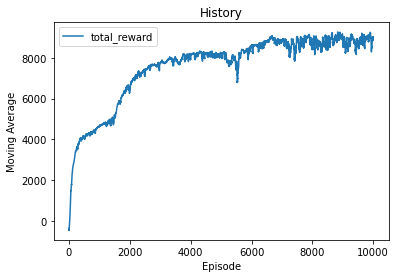

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(history, title, avg_span=30):
    fig1, ax1 = plt.subplots()
    x = range(len(history))
    cumsum = np.cumsum(history)
    avgs = [cumsum[ep]/(ep+1) if ep<avg_span else (cumsum[ep]-cumsum[ep-avg_span])/avg_span for ep in x]
    ax1.plot(x, avgs, label=title)
    ax1.set_title("History")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Moving Average")
    ax1.legend()

plot(history, 'total_reward')